# Text2Chart


## Setting
 - Auto Reload
 - path for utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
module_path = "../.."
sys.path.append(os.path.abspath(module_path))

## 1. Create Bedrock client

In [4]:
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [5]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: us-east-1
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1'

## 2. LLM 정의

In [6]:
from utils.bedrock import bedrock_model
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [7]:
llm_text = bedrock_model(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-5-Sonnet"),
    bedrock_client=boto3_bedrock,
    stream=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    inference_config={
        'maxTokens': 1024,
        'stopSequences': ["\n\nHuman"],
        'temperature': 0.01,
        #'topP': ...,
    }
    #additional_model_request_fields={"top_k": 200}
)

## 3. Analysis

In [34]:
import pprint
from textwrap import dedent
from utils.bedrock import bedrock_utils
from typing import TypedDict, Literal, Any
from src.genai_anaysis import llm_call
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig
from langchain_experimental.tools.python.tool import PythonAstREPLTool

### 3.1 Agent state 

In [35]:
class GraphState(TypedDict):
    ask: list[str]
    target_apps: list[str]
    ask_refo: str
    code: str

In [71]:
class genai_analyzer():

    def __init__(self, **kwargs):

        self.llm = kwargs["llm"]
        self.df = kwargs["df"]
        self.column_info = kwargs["column_info"]
        self.state = GraphState

        self.llm_caller = llm_call(llm=self.llm, verbose=False) 

        self._graph_definition()
        self.messages = []

    def _get_string_from_message(self, message):
        return message["content"][0]["text"]

    def _get_message_from_string(self, role, string):
        return {
            "role": role,
            "content": [{"text": dedent(string)}]
        }

    def get_messages(self, ):
        return self.messages
        
    def _graph_definition(self, **kwargs):

        def agent(state):

            print("---CALL AGENT---")
            ask = state["ask"]

            """
            현재 상태를 기반으로 에이전트 모델을 호출하여 응답을 생성합니다. 질문에 따라 검색 도구를 사용하여 검색을 결정하거나 단순히 종료합니다.
        
            Args:
                state (messages): 현재 상태
        
            Returns:
                state (messages): 현재 상태 메시지에 에이전트 응답이 추가된 업데이트된 상태
            """

            system_prompts = dedent(
                '''
                <task>
                사용자 메시지를 분석하여 차트 생성 여부를 결정하는 에이전트 역할 수행
                </task>
                
                <instruction>
                1. 사용자 메시지를 주의 깊게 분석하세요.
                2. 차트, 그래프, 데이터 시각화와 관련된 키워드를 찾으세요.
                3. 수치 데이터나 통계 정보의 존재 여부를 확인하세요.
                4. 분석 결과를 바탕으로 차트 생성 필요성을 판단하세요.
                5. 판단이 모호한 경우, 사용자에게 직접 차트 생성 의도를 물어보세요.
                </instruction>
                
                <consideration>
                - 사용자의 의도를 정확히 파악하는 것이 중요합니다.
                - 명시적인 차트 요청이 없더라도 데이터 시각화가 유용할 수 있는 상황을 고려하세요.
                - 주어진 데이터 (dataset) 및 컬럼 정보 (column_info)를 참고하여 생성 가능 여부 또한 고려하세요.
                - 단순한 질문이나 대화 종료 요청은 차트 생성이 불필요할 수 있습니다.
                - 기존 요청 결과에 대한 추가사항이라고 판단되면, 추가 코드 생성을 하지 말고 "GENERATE_CHART"를 출력하세요.
                </consideration>
                
                <output_format>
                결정에 따라 다음 중 하나를 출력하세요:
                1. "GENERATE_CHART (간단한 이유)" - 차트 생성이 필요한 경우
                2. "END (간단한 이유)" - 차트 생성이 불필요하거나 대화를 종료해야 하는 경우
                
                예시:
                GENERATE_CHART (사용자가 연간 수익 추이 그래프 요청)
                END (단순한 날씨 질문으로 차트 불필요)
                </output_format>

                This is the result of `print(df.head())`: <dataset>{dataset}</dataset>

                Here is the column information in detail, this is the results of `print(column_info)`: <column_info>{column_info}</column_info>
                
                '''
            )

            context = {
                "dataset": str(self.df.sample(10, random_state=0).to_csv()),
                "column_info": str(self.column_info.to_csv())
            }
            system_prompts = system_prompts.format(**context)
            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)

            

            message = self._get_message_from_string(role="user", string=ask)
            self.messages.append(message)

            print (self.messages)

            
            #messages = state["messages"]
            resp, messages_updated = self.llm_caller.invoke(messages=self.messages, system_prompts=system_prompts)
            self.messages = messages_updated
            
            return self.state(ask=ask)

        def should_chart_generation(state):
            """
            에이전트가 차트를 생성하는데 있어 추가적으로 고려해야 하는 상황이 있는지 결정합니다.
        
            이 함수는 상태의 마지막 메시지에서 함수 호출을 확인합니다. 함수 호출이 있으면 정보 검색 프로세스를 계속합니다. 그렇지 않으면 프로세스를 종료합니다.
        
            Args:
                state (messages): 현재 상태
        
            Returns:
                str: 검색 프로세스를 "계속"하거나 "종료"하는 결정
            """
        
            print("\n---DECIDE TO CHART GENERATION---")
            #messages = state["messages"]
            last_message = self._get_string_from_message(self.messages[-1])
            
            # 함수 호출이 없으면 종료합니다.
            if "GENERATE_CHART" not in last_message:
                print("---DECISION: DO NOT CHART GENERATION / DONE---")
                return "end"
            # 그렇지 않으면 함수 호출이 있으므로 계속합니다.
            else:
                print("---DECISION: CHART GENERATION---")
                return "continue"

        def ask_reformulation(state):

            print("---ASK REFORMULATION---")
            #messages = state["messages"]
            ask = state["ask"]

            system_prompts = dedent(
                '''
                당신은 사용자의 텍스트 요청을 분석하여 중요한 정보를 추출하는 전문가입니다.
                주어진 structured dataset(df)에 대한 분석 요청(request)을 처리하는 것이 당신의 주요 임무입니다.

                <task>
                1. 사용자의 텍스트 요청에서 분석 대상이 되는 target app의 이름을 식별하고 추출하세요.
                2. 사용자의 구체적인 분석 요청 사항을 분석하고, 필요하다면 결과를 차트로 표현하기 적합현 형태로 요청 사항을 수정해 주세요.
                </task>
                
                <output_format>
                JSON 형식으로 다음 정보를 포함하여 응답하세요:
                {{
                  "target_apps": ["추출된 앱 이름"],
                  "ask_reformulation": "파악된 분석 요청 사항"
                }}
                </output_format>

                <instruction>
                - target app이 명시적으로 언급되지 않은 경우, "target_app" 필드를 "unspecified"로 설정하세요.
                - target app이 복수 개인 경우, list 형태로 모두 언급하세요. 예를 들자면 ["앱 이름 1", "앱 이름 2"]로 표현합니다. 
                - 분석 요청이 불명확한 경우, 가능한 한 사용자의 의도를 추론하여 "ask_reformulation" 필드를 작성하세요.
                - 추출 및 파악한 정보만을 간결하게 제공하고, 추가적인 설명이나 해석은 하지 마세요.
                </instruction>

                이 정보를 바탕으로 다음 노드가 적절한 분석을 수행할 수 있도록 정확하고 명확한 정보를 제공하는 것이 중요합니다.
                '''
            )
            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)

            user_prompts = dedent(
                '''
                This is the result of `print(df.head())`: <dataset>{dataset}</dataset>
                Here is the column information in detail, this is the results of `print(column_info)`: <column_info>{column_info}</column_info>
                Here is user's request: <request>{ask}</request>
                '''
            )
            context = {
                "dataset": str(self.df.sample(10, random_state=0).to_csv()),
                "column_info": str(self.column_info.to_csv()),
                "ask": ask
            }
            user_prompts = user_prompts.format(**context)
            
            message = self._get_message_from_string(role="user", string=user_prompts)            
            self.messages.append(message)

            resp, messages_updated = self.llm_caller.invoke(messages=self.messages, system_prompts=system_prompts)

            results = eval(resp['text'])
            target_apps, ask_reformulation = results["target_apps"], results["ask_reformulation"]
            self.messages=messages_updated

            return self.state(target_apps=target_apps, ask_refo=ask_reformulation)

        def code_generation_for_chart(state):

            print("---CODE GENERATION FOR CHART---")
            ask_reformulation = state["ask_refo"]

            system_prompts = dedent(
                '''
                당신은 데이터 분석과 시각화 전문가입니다.
                주어진 structured dataset, dataset의 컬럼 정보, 그리고 사용자의 분석 요청사항을 바탕으로 적절한 차트를 생성하는 Python 코드를 작성하는 것이 당신의 임무입니다.

                <task>
                사용자의 요청에 적합한 차트생성 python 코드 작성
                </task>

                <input>
                1. dataset: 분석할 데이터셋
                2. column_info: 각 컬럼의 이름과 데이터 타입
                3. question: 어떤 분석을 원하는지에 대한 설명
                </input>
                
                <output_format>
                JSON 형식으로 다음 정보를 포함하여 응답하세요:
                {{
                    "code": """사용자의 요청을 충족시키는 차트를 생성하는 Python 코드"""
                }}
                </output_format>

                <instruction>
                1. 데이터셋과 컬럼 정보를 신중히 분석하세요.
                2. 사용자의 분석 요청사항을 정확히 이해하세요.
                3. 요청사항에 가장 적합한 차트 유형을 선택하세요 (예: 막대 그래프, 선 그래프, 산점도, 파이 차트 등).
                4. 선택한 차트 유형에 맞는 Python 라이브러리를 사용하세요 (예: matplotlib, seaborn, plotly 등).
                5. 데이터 전처리가 필요한 경우 pandas를 사용하여 데이터를 적절히 가공하세요.
                6. 차트의 제목, 축 레이블, 범례 등을 명확하게 설정하세요.
                7. 필요한 경우 차트의 색상, 스타일, 크기 등을 조정하여 가독성을 높이세요.
                8. 코드에 주석을 달아 각 단계를 설명하세요.
                9. 코드 실행 시 발생할 수 있는 예외 상황을 고려하여 적절한 예외 처리를 포함하세요.
                10. 생성된 차트를 저장하거나 표시하는 코드를 포함하세요.
                11. 생성된 코드 수행에 필요한 패키지들은 반드시 import 하세요.
                12. 차트는 모두 영어로 표현해 주세요.
                </instruction>

                <consideration>
                1. 사용자가 제공한 데이터셋의 구조와 크기에 따라 코드를 최적화하세요.
                2. 복잡한 분석 요청의 경우, 단계별로 접근하여 중간 결과를 확인할 수 있도록 코드를 구성하세요.
                3. 데이터의 특성에 따라 적절한 정규화나 스케일링을 고려하세요.
                4. 대규모 데이터셋의 경우 성능을 고려하여 코드를 작성하세요.
                5. "plt.style.use('seaborn')" 코드는 사용하지 마세요.
                6. python의 string code 수행방법(exec())을 사용하려고 합니다. "unterminated string literal" 에러가 발생하지 않게 코드를 작성하세요.
                6. 이 지침을 따라 사용자의 요청에 맞는 정확하고 효과적인 차트 생성 코드를 작성하고, JSON 형식으로 출력하세요.
                7. 차트는 show()함수를 통해 시각화하며, "chart.png"로 저장하세요.
                </consideration>
                '''
            )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)

            user_prompts = dedent(
                '''
                This is the result of `print(df.head())`: <dataset>{dataset}</dataset>
                Here is the column information in detail, this is the results of `print(column_info)`: <column_info>{column_info}</column_info>
                Here is the question: <ask>{ask}</ask>
                Variable `df: pd.DataFrame` is already declared.
                
                '''
            )

            context = {
                "dataset": str(self.df.sample(10, random_state=0).to_csv()),
                "column_info": str(self.column_info.to_csv()),
                "ask": ask_reformulation
            }
            user_prompts = user_prompts.format(**context)
            
            message = self._get_message_from_string(role="user", string=user_prompts)            
            self.messages.append(message)

            resp, messages_updated = self.llm_caller.invoke(messages=self.messages, system_prompts=system_prompts)
            self.messages = messages_updated
            
            results = eval(resp['text'])
            code = results["code"]

            return self.state(code=code)

        def chart_generation(state):

            print("---CHART GENERATION---")
            df, code = self.df, state["code"]
            results = exec(code, {"df": df})

            return state
            
        # langgraph.graph에서 StateGraph와 END를 가져옵니다.
        workflow = StateGraph(self.state)

        # Todo 를 작성합니다.
        workflow.add_node("agent", agent)  # 에이전트 노드를 추가합니다.
        workflow.add_node("ask_reformulation", ask_reformulation)  # 요청을 차트생성에 용이하게 수정하는 노드를 추가합니다.
        workflow.add_node("code_generation_for_chart", code_generation_for_chart)  # 차트 생성을 위한 코드 생성 노드를 추가합니다.
        workflow.add_node("chart_generation", chart_generation)  # 생성된 코드를 실행하여 노드를 생성하는 노드를 추가합니다.
        
        # 각 노드들을 연결합니다.
        workflow.add_conditional_edges(
            "agent",
            # 에이전트 결정 평가
            should_chart_generation,
            {
                # 도구 노드 호출
                "continue": "ask_reformulation",
                "end": END,
            },
        )
        workflow.add_edge("ask_reformulation", "code_generation_for_chart")
        workflow.add_edge("code_generation_for_chart", "chart_generation")
        workflow.add_edge("chart_generation", END)

        # 시작점을 설정합니다.
        workflow.set_entry_point("agent")

        # 기록을 위한 메모리 저장소를 설정합니다.
        memory = MemorySaver()

        # 그래프를 컴파일합니다.
        self.app = workflow.compile(checkpointer=memory)        
        self.config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "Text2Chart"})

    def invoke(self, **kwargs):
        
        inputs = self.state(ask=kwargs["ask"])
        # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
        for output in self.app.stream(inputs, self.config):
            # 출력된 결과에서 키와 값을 순회합니다.
            for key, value in output.items():
                # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
                pprint.pprint(f"Output from node '{key}':")
                pprint.pprint("---")
                # 출력 값을 예쁘게 출력합니다.
                pprint.pprint(value, indent=2, width=80, depth=None)
            # 각 출력 사이에 구분선을 추가합니다.
            pprint.pprint("\n---\n")
    
    def show_graph(self, ):
        
        from IPython.display import Image, display

        try:
            display(
                Image(self.app.get_graph(xray=True).draw_mermaid_png())
            )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
            # xray=True는 추가적인 세부 정보를 포함합니다.
        except:
            # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
            pass

            

In [72]:
import pandas as pd
from langgraph.graph import END, StateGraph

In [73]:
df = pd.read_csv("./dataset/app_power_consumption.csv")
column_info = pd.read_csv("dataset/column_info.csv")

In [74]:
analyzer = genai_analyzer(
    llm=llm_text,
    df=df,
    column_info=column_info
)

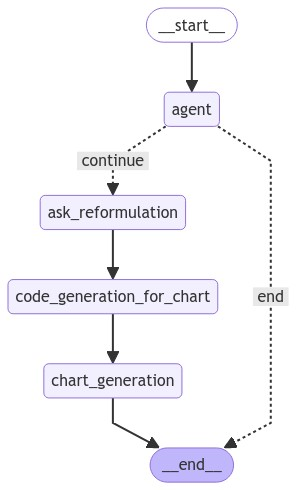

In [75]:
analyzer.show_graph()

In [76]:
analyzer.invoke(
    ask=dedent("앱 f의 날짜별 소비전력")
)

---CALL AGENT---
[{'role': 'user', 'content': [{'text': '앱 f의 날짜별 소비전력'}]}]
END (앱 f에 대한 데이터가 주어진 데이터셋에 존재하지 않음)
---DECIDE TO CHART GENERATION---
---DECISION: DO NOT CHART GENERATION / DONE---
"Output from node 'agent':"
'---'
{'ask': '앱 f의 날짜별 소비전력'}
'\n---\n'


---CALL AGENT---
[{'role': 'user', 'content': [{'text': '2주전의 a, b, c앱의 소비전력을 비교해줘. 전력이 가장 큰 지점을 표시해줘'}]}]
GENERATE_CHART (사용자가 특정 앱들의 전력 소비 비교와 최대값 표시를 요청하여 시각화가 필요함)
---DECIDE TO CHART GENERATION---
---DECISION: CHART GENERATION---
"Output from node 'agent':"
'---'
{'ask': '2주전의 a, b, c앱의 소비전력을 비교해줘. 전력이 가장 큰 지점을 표시해줘'}
'\n---\n'
---ASK REFORMULATION---
{
  "target_apps": ["app_a", "app_b", "app_c"],
  "ask_reformulation": "2주 전 날짜의 app_a, app_b, app_c의 전력 사용량을 비교하고, 가장 높은 전력 사용량을 표시해주세요."
}"Output from node 'ask_reformulation':"
'---'
{ 'ask_refo': '2주 전 날짜의 app_a, app_b, app_c의 전력 사용량을 비교하고, 가장 높은 전력 사용량을 '
              '표시해주세요.',
  'target_apps': ['app_a', 'app_b', 'app_c']}
'\n---\n'
---CODE GENERATION FOR CHART---
{
    "code": """
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 날짜를 datetime 형식으로 변환
df['날짜'] = pd.to_datetime(df['날짜'])

# 현재 날짜 (데이터셋의 가장 최근 날짜)
current_date = df['날짜'].max()

# 2주 전 날짜 계산
two_weeks_ago = current_dat

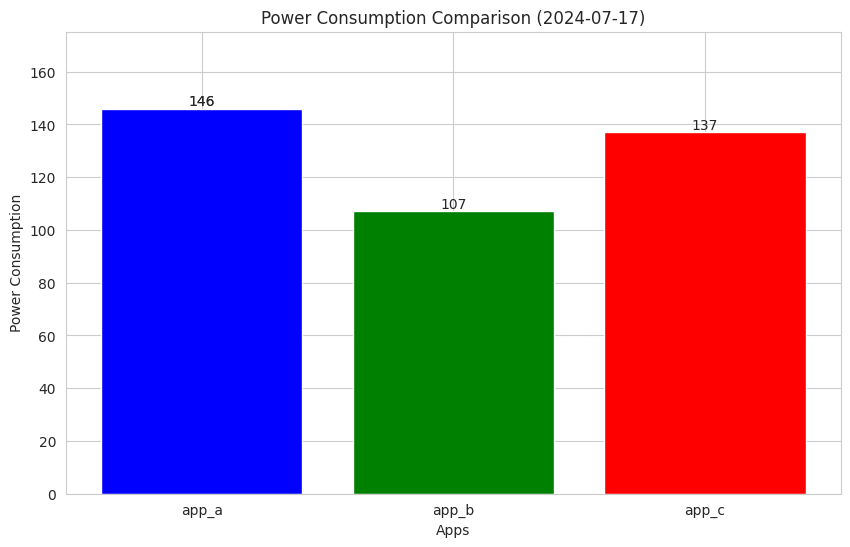

"Output from node 'chart_generation':"
'---'
{ 'ask': '2주전의 a, b, c앱의 소비전력을 비교해줘. 전력이 가장 큰 지점을 표시해줘',
  'ask_refo': '2주 전 날짜의 app_a, app_b, app_c의 전력 사용량을 비교하고, 가장 높은 전력 사용량을 '
              '표시해주세요.',
  'code': '\n'
          'import pandas as pd\n'
          'import matplotlib.pyplot as plt\n'
          'from datetime import datetime, timedelta\n'
          '\n'
          '# 날짜를 datetime 형식으로 변환\n'
          "df['날짜'] = pd.to_datetime(df['날짜'])\n"
          '\n'
          '# 현재 날짜 (데이터셋의 가장 최근 날짜)\n'
          "current_date = df['날짜'].max()\n"
          '\n'
          '# 2주 전 날짜 계산\n'
          'two_weeks_ago = current_date - timedelta(weeks=2)\n'
          '\n'
          '# 2주 전 날짜의 데이터 추출\n'
          "target_data = df[df['날짜'] == two_weeks_ago]\n"
          '\n'
          'if target_data.empty:\n'
          '    print("2주 전 날짜의 데이터가 없습니다.")\n'
          'else:\n'
          '    # 필요한 앱 데이터 추출\n'
          "    apps = ['app_a', 'app_b', 'app_c']\n"
          '    power_usage = targ

In [61]:
analyzer.invoke(
    ask=dedent("2주전의 a, b, c앱의 소비전력을 비교해줘. 전력이 가장 큰 지점을 표시해줘")
)

---CALL AGENT---
[{'role': 'user', 'content': [{'text': '2주전의 a, b, c앱의 소비전력을 비교해줘. 전력이 가장 큰 지점을 표시해줘'}]}, {'role': 'assistant', 'content': [{'text': 'GENERATE_CHART (사용자가 특정 앱들의 전력 소비 비교와 최대값 표시를 요청하여 시각화가 필요함)'}]}, {'role': 'user', 'content': [{'text': "\nThis is the result of `print(df.head())`: <dataset>,날짜,app_a,app_b,app_c,app_d,app_e\n2,2024-05-03,128,156,99,100,90\n33,2024-06-03,89,139,117,133,146\n22,2024-05-23,81,142,124,138,94\n16,2024-05-17,84,139,139,148,151\n13,2024-05-14,156,109,111,125,93\n24,2024-05-25,108,139,121,105,110\n60,2024-06-30,153,100,102,100,136\n76,2024-07-16,155,125,84,153,126\n80,2024-07-20,158,109,95,102,92\n68,2024-07-08,118,148,159,126,136\n</dataset>\nHere is the column information in detail, this is the results of `print(column_info)`: <column_info>,컬럼 명,컬럼 한글명,DATA TYPE\n0,날짜,날짜,DATE\n1,app_a,app a의 전력사용 양,BIGINT\n2,app_b,app b의 전력사용 양,BIGINT\n3,app_c,app c의 전력사용 양,BIGINT\n4,app_d,app d의 전력사용 양,BIGINT\n5,app_e,app e의 전력사용 양,BIGINT\n</column_info>\nH

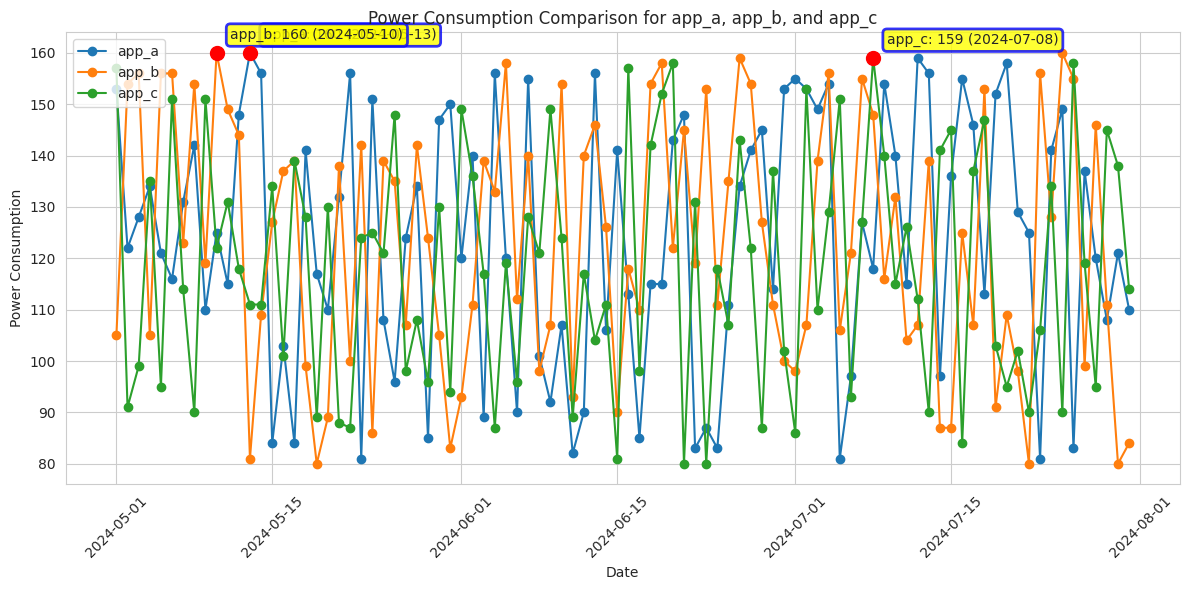

"Output from node 'chart_generation':"
'---'
{ 'ask': '가장 큰 전력을 쓴 날짜도 표시해줘',
  'ask_refo': 'app_a, app_b, app_c의 전력 사용량을 비교하고, 각 앱별로 가장 큰 전력을 사용한 날짜와 그 값을 '
              '표시해주세요.',
  'code': '\n'
          'import pandas as pd\n'
          'import matplotlib.pyplot as plt\n'
          'import seaborn as sns\n'
          '\n'
          '# 날짜를 datetime 형식으로 변환\n'
          "df['날짜'] = pd.to_datetime(df['날짜'])\n"
          '\n'
          '# 필요한 앱 데이터 추출\n'
          "apps = ['app_a', 'app_b', 'app_c']\n"
          '\n'
          '# 각 앱별로 최대 전력 사용량과 해당 날짜 찾기\n'
          'max_power = {}\n'
          'for app in apps:\n'
          '    max_row = df.loc[df[app].idxmax()]\n'
          '    max_power[app] = {\n'
          "        'value': max_row[app],\n"
          "        'date': max_row['날짜']\n"
          '    }\n'
          '\n'
          '# 그래프 설정\n'
          'plt.figure(figsize=(12, 6))\n'
          'sns.set_style("whitegrid")\n'
          '\n'
          '# 선 그래프 그리기\n'
          'for

In [62]:
analyzer.invoke(
    ask=dedent("가장 큰 전력을 쓴 날짜도 표시해줘")
)

---CALL AGENT---
[{'role': 'user', 'content': [{'text': '2주전의 a, b, c앱의 소비전력을 비교해줘. 전력이 가장 큰 지점을 표시해줘'}]}, {'role': 'assistant', 'content': [{'text': 'GENERATE_CHART (사용자가 특정 앱들의 전력 소비 비교와 최대값 표시를 요청하여 시각화가 필요함)'}]}, {'role': 'user', 'content': [{'text': "\nThis is the result of `print(df.head())`: <dataset>,날짜,app_a,app_b,app_c,app_d,app_e\n2,2024-05-03,128,156,99,100,90\n33,2024-06-03,89,139,117,133,146\n22,2024-05-23,81,142,124,138,94\n16,2024-05-17,84,139,139,148,151\n13,2024-05-14,156,109,111,125,93\n24,2024-05-25,108,139,121,105,110\n60,2024-06-30,153,100,102,100,136\n76,2024-07-16,155,125,84,153,126\n80,2024-07-20,158,109,95,102,92\n68,2024-07-08,118,148,159,126,136\n</dataset>\nHere is the column information in detail, this is the results of `print(column_info)`: <column_info>,컬럼 명,컬럼 한글명,DATA TYPE\n0,날짜,날짜,DATE\n1,app_a,app a의 전력사용 양,BIGINT\n2,app_b,app b의 전력사용 양,BIGINT\n3,app_c,app c의 전력사용 양,BIGINT\n4,app_d,app d의 전력사용 양,BIGINT\n5,app_e,app e의 전력사용 양,BIGINT\n</column_info>\nH

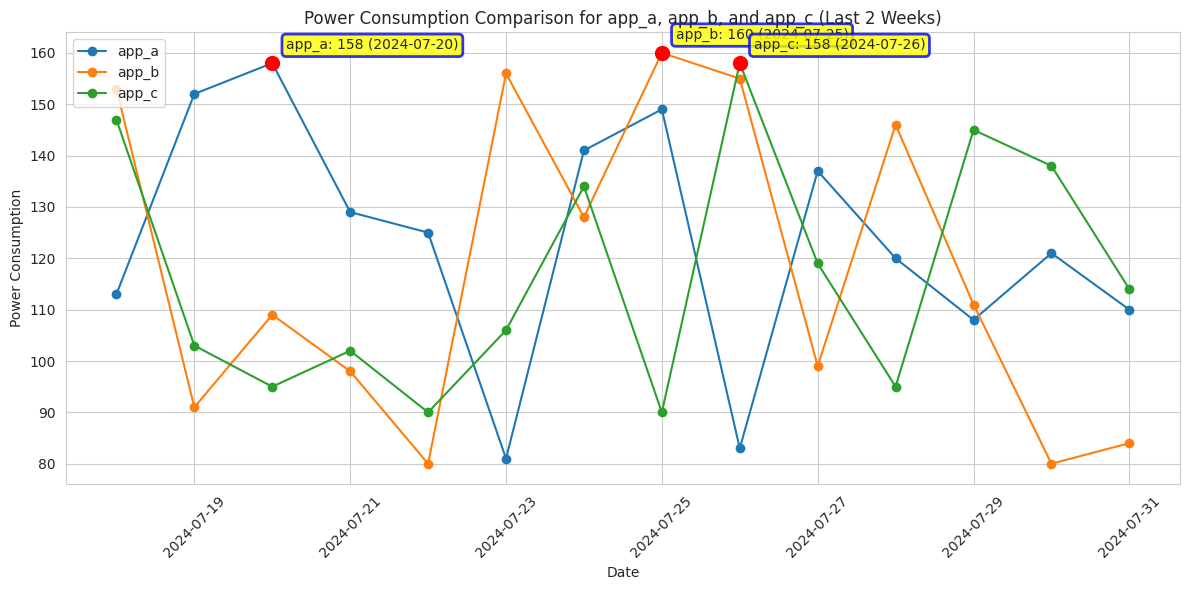

"Output from node 'chart_generation':"
'---'
{ 'ask': '지난 2주에 대해서만 그려줘',
  'ask_refo': '지난 2주 동안의 app_a, app_b, app_c의 전력 사용량을 비교하고, 각 앱별로 이 기간 내 가장 큰 '
              '전력을 사용한 날짜와 그 값을 표시해주세요.',
  'code': '\n'
          'import pandas as pd\n'
          'import matplotlib.pyplot as plt\n'
          'import seaborn as sns\n'
          'from datetime import timedelta\n'
          '\n'
          '# 날짜를 datetime 형식으로 변환\n'
          "df['날짜'] = pd.to_datetime(df['날짜'])\n"
          '\n'
          '# 가장 최근 날짜 찾기\n'
          "latest_date = df['날짜'].max()\n"
          '\n'
          '# 2주 전 날짜 계산\n'
          'two_weeks_ago = latest_date - timedelta(days=14)\n'
          '\n'
          '# 지난 2주 데이터 필터링\n'
          "df_last_2weeks = df[(df['날짜'] > two_weeks_ago) & (df['날짜'] <= "
          'latest_date)]\n'
          '\n'
          '# 필요한 앱 데이터 추출\n'
          "apps = ['app_a', 'app_b', 'app_c']\n"
          '\n'
          '# 각 앱별로 최대 전력 사용량과 해당 날짜 찾기\n'
          'max_power = {}\n'
         

In [63]:
analyzer.invoke(
    ask=dedent("지난 2주에 대해서만 그려줘")
)

---CALL AGENT---
[{'role': 'user', 'content': [{'text': '요일별 a 앱의 평균 소비 전력를 알려줘. 에러바를 이용해서 알려줘'}]}, {'role': 'assistant', 'content': [{'text': 'GENERATE_CHART (요일별 app_a의 평균 소비 전력과 에러바를 시각화하는 차트 생성 필요)'}]}, {'role': 'user', 'content': [{'text': "\nThis is the result of `print(df.head())`: <dataset>,날짜,app_a,app_b,app_c,app_d,app_e\n2,2024-05-03,128,156,99,100,90\n33,2024-06-03,89,139,117,133,146\n22,2024-05-23,81,142,124,138,94\n16,2024-05-17,84,139,139,148,151\n13,2024-05-14,156,109,111,125,93\n24,2024-05-25,108,139,121,105,110\n60,2024-06-30,153,100,102,100,136\n76,2024-07-16,155,125,84,153,126\n80,2024-07-20,158,109,95,102,92\n68,2024-07-08,118,148,159,126,136\n</dataset>\nHere is the column information in detail, this is the results of `print(column_info)`: <column_info>,컬럼 명,컬럼 한글명,DATA TYPE\n0,날짜,날짜,DATE\n1,app_a,app a의 전력사용 양,BIGINT\n2,app_b,app b의 전력사용 양,BIGINT\n3,app_c,app c의 전력사용 양,BIGINT\n4,app_d,app d의 전력사용 양,BIGINT\n5,app_e,app e의 전력사용 양,BIGINT\n</column_info>\nHere is use

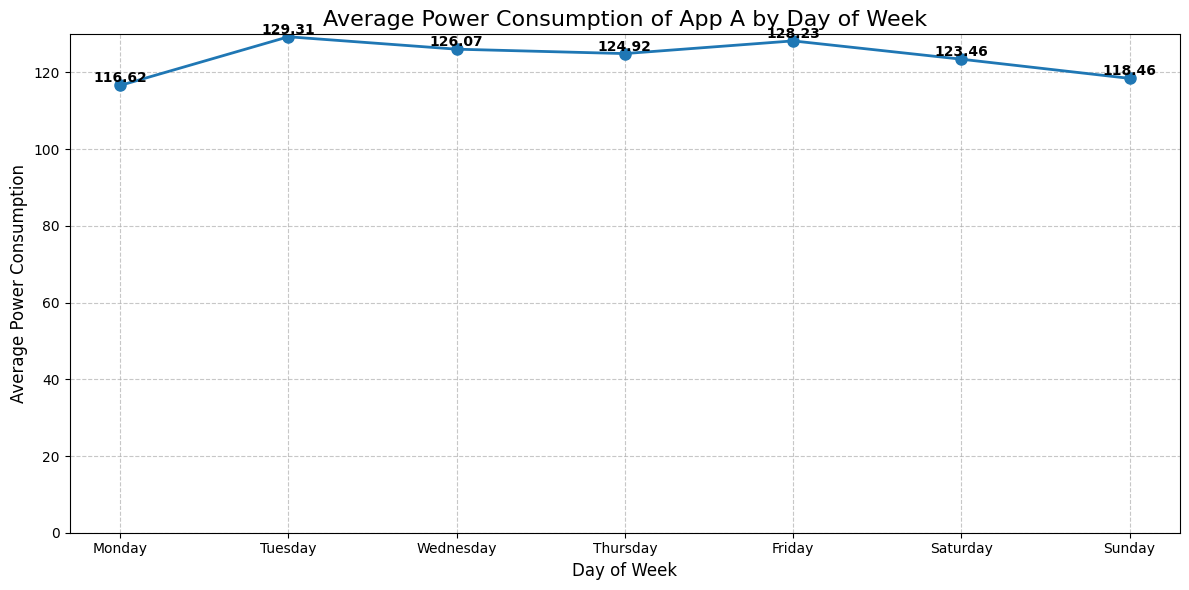

"Output from node 'chart_generation':"
'---'
{ 'ask': '라인 그래프로 보여줄래?',
  'ask_refo': '요일별 app_a의 평균 소비 전력을 계산하고, 라인 그래프로 시각화해주세요.',
  'code': '\n'
          'import pandas as pd\n'
          'import matplotlib.pyplot as plt\n'
          '\n'
          '# 요일별 app_a의 평균 계산\n'
          "daily_avg = df.groupby('요일')['app_a'].mean()\n"
          '\n'
          '# 요일 이름 리스트 생성\n'
          "days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', "
          "'Saturday', 'Sunday']\n"
          '\n'
          '# 그래프 생성\n'
          'plt.figure(figsize=(12, 6))\n'
          "plt.plot(days, daily_avg, marker='o', linestyle='-', linewidth=2, "
          'markersize=8)\n'
          '\n'
          '# 그래프 꾸미기\n'
          "plt.title('Average Power Consumption of App A by Day of Week', "
          'fontsize=16)\n'
          "plt.xlabel('Day of Week', fontsize=12)\n"
          "plt.ylabel('Average Power Consumption', fontsize=12)\n"
          "plt.grid(True, linestyle='--', alpha=0.7)\n"
    

In [47]:
analyzer.invoke(
    ask=dedent("라인 그래프로 보여줄래?")
)

---CALL AGENT---
[{'role': 'user', 'content': [{'text': '요일별 a 앱의 평균 소비 전력를 알려줘. 에러바를 이용해서 알려줘'}]}, {'role': 'assistant', 'content': [{'text': 'GENERATE_CHART (요일별 app_a의 평균 소비 전력과 에러바를 시각화하는 차트 요청)'}]}, {'role': 'user', 'content': [{'text': "\nThis is the result of `print(df.head())`: <dataset>,날짜,app_a,app_b,app_c,app_d,app_e\n2,2024-05-03,128,156,99,100,90\n33,2024-06-03,89,139,117,133,146\n22,2024-05-23,81,142,124,138,94\n16,2024-05-17,84,139,139,148,151\n13,2024-05-14,156,109,111,125,93\n24,2024-05-25,108,139,121,105,110\n60,2024-06-30,153,100,102,100,136\n76,2024-07-16,155,125,84,153,126\n80,2024-07-20,158,109,95,102,92\n68,2024-07-08,118,148,159,126,136\n</dataset>\nHere is the column information in detail, this is the results of `print(column_info)`: <column_info>,컬럼 명,컬럼 한글명,DATA TYPE\n0,날짜,날짜,DATE\n1,app_a,app a의 전력사용 양,BIGINT\n2,app_b,app b의 전력사용 양,BIGINT\n3,app_c,app c의 전력사용 양,BIGINT\n4,app_d,app d의 전력사용 양,BIGINT\n5,app_e,app e의 전력사용 양,BIGINT\n</column_info>\nHere is user's

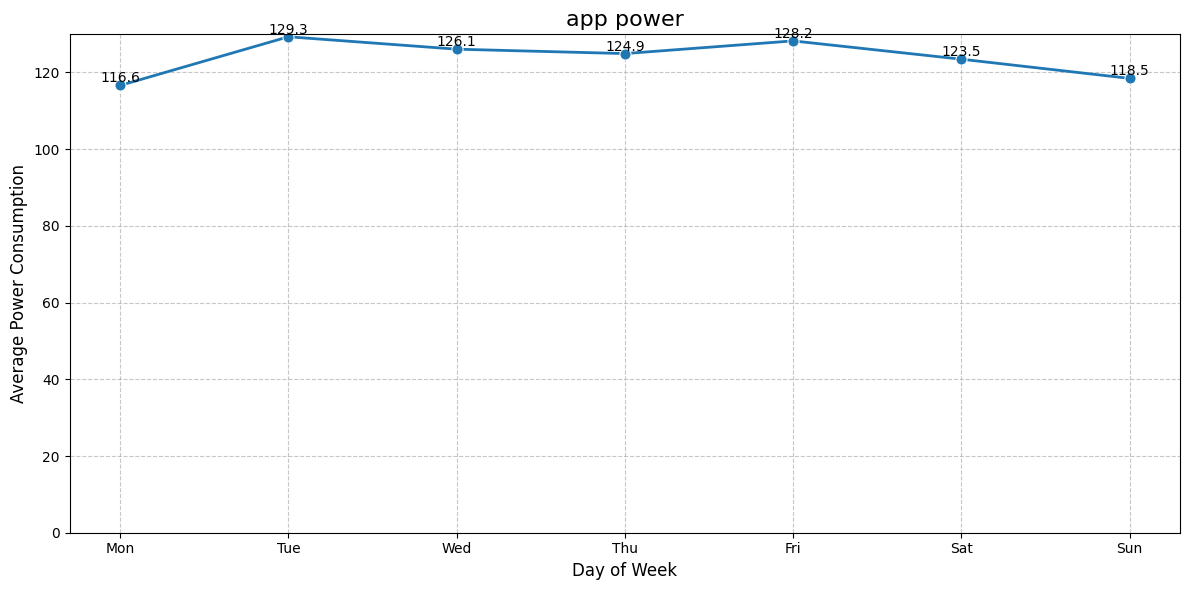

"Output from node 'chart_generation':"
'---'
{ 'ask': "제목을 'app power'로 변경해줘",
  'ask_refo': "요일별 app_a의 평균 소비 전력을 계산하고, 라인 그래프로 시각화해주세요. 그래프의 제목을 'app "
              "power'로 설정해주세요.",
  'code': '\n'
          'import pandas as pd\n'
          'import matplotlib.pyplot as plt\n'
          'import seaborn as sns\n'
          '\n'
          '# 요일별 app_a의 평균 계산\n'
          "daily_avg = df.groupby('요일')['app_a'].mean().reset_index()\n"
          '\n'
          '# 요일 이름 리스트 생성\n'
          "day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']\n"
          "daily_avg['요일_이름'] = daily_avg['요일'].map(lambda x: day_names[x])\n"
          '\n'
          '# 요일 순서대로 정렬\n'
          "daily_avg = daily_avg.sort_values('요일')\n"
          '\n'
          '# 그래프 생성\n'
          'plt.figure(figsize=(12, 6))\n'
          "sns.lineplot(x='요일_이름', y='app_a', data=daily_avg, \n"
          "             marker='o', linewidth=2, markersize=8)\n"
          '\n'
          '# 그래프 꾸미기\n'
          "plt.

In [33]:
analyzer.invoke(
    ask=dedent("제목을 'app power'로 변경해줘")
)

In [132]:
pprint.pprint(analyzer.get_messages())

[{'content': [{'text': '요일별 a 앱의 평균 소비 전력를 알려줘. 에러바를 이용해서 알려줘'}],
  'role': 'user'},
 {'content': [{'text': 'GENERATE_CHART (요일별 app_a의 평균 전력 소비와 에러바를 시각화하는 차트 '
                       '필요)'}],
  'role': 'assistant'},
 {'content': [{'text': '\n'
                       '<task>\n'
                       '1. 사용자의 텍스트 요청에서 분석 대상이 되는 target app의 이름을 식별하고 '
                       '추출하세요.\n'
                       '2. 사용자의 구체적인 분석 요청 사항을 분석하고, 필요하다면 결과를 차트로 표현하기 적합현 '
                       '형태로 요청 사항을 수정해 주세요.\n'
                       '</task>\n'
                       '\n'
                       '<output_format>\n'
                       'JSON 형식으로 다음 정보를 포함하여 응답하세요:\n'
                       '{\n'
                       '  "target_apps": ["추출된 앱 이름"],\n'
                       '  "ask_reformulation": "파악된 분석 요청 사항"\n'
                       '}\n'
                       '</output_format>\n'
                       '\n'
                       '<instruction>\n'
                       '- targe

In [61]:
analyzer.invoke(
    messages=[
        {
            "role": "user",
            "content": [{"text": dedent("요일별 a 앱의 평균 소비 전력를 알려줘. 에러바를 이용해서 알려줘")}]
        }
    ]
)

KeyError: 'ask'

In [56]:
analyzer.get_messages()

[{'role': 'user',
  'content': [{'text': '요일별 a 앱의 평균 소비 전력를 알려줘. 에러바를 이용해서 알려줘'}]},
 {'role': 'assistant',
  'content': [{'text': 'GENERATE_CHART (요일별 app_a의 평균 전력 소비량과 에러바를 포함한 차트 생성 요청)'}]},
 {'role': 'user',
  'content': [{'text': '\n<task>\n1. 사용자의 텍스트 요청에서 분석 대상이 되는 target app의 이름을 식별하고 추출하세요.\n2. 사용자의 구체적인 분석 요청 사항을 분석하고, 필요하다면 결과를 차트로 표현하기 적합현 형태로 요청 사항을 수정해 주세요.\n</task>\n\n<output_format>\nJSON 형식으로 다음 정보를 포함하여 응답하세요:\n{\n  "target_apps": ["추출된 앱 이름"],\n  "ask_reformulation": "파악된 분석 요청 사항"\n}\n</output_format>\n\n<instruction>\n- target app이 명시적으로 언급되지 않은 경우, "target_app" 필드를 "unspecified"로 설정하세요.\n- target app이 복수 개인 경우, list 형태로 모두 언급하세요. 예를 들자면 ["앱 이름 1", "앱 이름 2"]로 표현합니다. \n- 분석 요청이 불명확한 경우, 가능한 한 사용자의 의도를 추론하여 "ask_reformulation" 필드를 작성하세요.\n- 추출 및 파악한 정보만을 간결하게 제공하고, 추가적인 설명이나 해석은 하지 마세요.\n</instruction>\n\n이 정보를 바탕으로 다음 노드가 적절한 분석을 수행할 수 있도록 정확하고 명확한 정보를 제공하는 것이 중요합니다.\n\nThis is the result of `print(df.head())`: <dataset>,날짜,app_a,app_b,app_c,app_d,app_e\n2,2024-05-0

### 3.1 Analyzer 정의

In [ ]:
import pandas as pd
from langgraph.graph import END, StateGraph

In [ ]:
df = pd.read_csv("./dataset/app_power_consumption.csv")
column_info = pd.read_csv("dataset/column_info.csv")
#state = GraphState()

In [ ]:
analyzer = app_analyzer(
    llm=llm_text,
    df=df,
    column_info=column_info
)

In [ ]:
analyzer.invoke(
    ask="요일별 a 앱의 평균 소비 전력를 알려줘. 에러바를 이용해서 알려줘"
)

In [ ]:
import numpy as np

In [ ]:
code = """
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Ensure the '날짜' column is in datetime format
df['날짜'] = pd.to_datetime(df['날짜'])

# Extract day of week (0 = Monday, 6 = Sunday)
df['day_of_week'] = df['날짜'].dt.dayofweek

# Dictionary to map day numbers to day names
day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df['day_name'] = df['day_of_week'].map(day_map)

# List of apps
apps = ['app_a', 'app_b', 'app_c', 'app_d', 'app_e']

# Calculate mean and standard error for each app and day
data = []
for app in apps:
    for day in range(7):
        mean = df[df['day_of_week'] == day][app].mean()
        std_error = df[df['day_of_week'] == day][app].std() / np.sqrt(len(df[df['day_of_week'] == day]))
        data.append({'app': app, 'day': day_map[day], 'mean': mean, 'std_error': std_error})

result_df = pd.DataFrame(data)

# Set up the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create the bar plot with error bars
ax = sns.barplot(x='day', y='mean', hue='app', data=result_df, 
                 palette='viridis', errorbar='se', capsize=0.1)

# Customize the plot
plt.title('Average Power Consumption by App and Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Power Consumption', fontsize=12)
plt.legend(title='App', title_fontsize='12', fontsize='10')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Save the plot (optional)
plt.savefig('power_consumption_by_app_and_day.png', dpi=300, bbox_inches='tight')
"""

In [ ]:
res = exec(code, {"df": df})

In [ ]:
tool = PythonAstREPLTool(locals={"df": df})
            
results = tool.invoke(code)
results

In [ ]:
resutls = '{\n    "code": """\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom datetime import datetime, timedelta\n\n# 날짜를 datetime 형식으로 변환\ndf[\'날짜\'] = pd.to_datetime(df[\'날짜\'])\n\n# 최근 날짜 찾기\nlatest_date = df[\'날짜\'].max()\n\n# 최근 7일 데이터 필터링\nseven_days_ago = latest_date - timedelta(days=6)\nrecent_data = df[df[\'날짜\'] >= seven_days_ago]\n\n# 앱 목록\napps = [\'app_a\', \'app_b\', \'app_c\', \'app_d\', \'app_e\']\n\n# 그래프 설정\nfig, ax = plt.subplots(figsize=(12, 6))\n\n# 막대 그래프 그리기\nbar_width = 0.15\nindex = range(7)\n\nfor i, app in enumerate(apps):\n    values = recent_data[app].values\n    ax.bar([x + i * bar_width for x in index], values, bar_width, label=app)\n\n# x축 레이블 설정\nax.set_xlabel(\'Date\')\nax.set_ylabel(\'Power Consumption\')\nax.set_title(\'Daily Power Consumption by App (Last 7 Days)\')\n\n# x축 눈금 설정\nax.set_xticks([x + bar_width * 2 for x in index])\nax.set_xticklabels(recent_data[\'날짜\'].dt.strftime(\'%Y-%m-%d\').values)\n\n# 범례 추가\nax.legend()\n\n# 그래프 표시\nplt.tight_layout()\nplt.show()\n\n# 그래프 저장 (선택사항)\n# plt.savefig(\'power_consumption_last_7_days.png\')\n    """,\n    "description": """이 코드는 주어진 데이터프레임에서 최근 7일간의 각 앱별 일일 전력 소비량을 계산하고 막대 그래프로 표시합니다. 주요 단계는 다음과 같습니다:\n\n1. 날짜 데이터를 datetime 형식으로 변환합니다.\n2. 최근 7일 데이터를 필터링합니다.\n3. matplotlib를 사용하여 막대 그래프를 생성합니다.\n4. 각 앱에 대해 다른 색상의 막대를 그립니다.\n5. x축에는 날짜, y축에는 전력 소비량을 표시합니다.\n6. 범례를 추가하여 각 막대가 어떤 앱을 나타내는지 표시합니다.\n\n생성된 차트는 최근 7일 동안 각 앱(app_a, app_b, app_c, app_d, app_e)의 일일 전력 소비량을 시각적으로 비교할 수 있게 해줍니다. 이를 통해 어떤 앱이 가장 많은 전력을 소비하는지, 소비 패턴이 시간에 따라 어떻게 변하는지 쉽게 파악할 수 있습니다."""}'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the 'day_of_week' column is present in the DataFrame
if 'day_of_week' not in df.columns:
    print("Error: 'day_of_week' column is missing from the DataFrame.")
    exit()

# Convert 'day_of_week' to categorical type with correct order
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=days_order, ordered=True)

# Calculate mean and standard error for each app by day of week
apps = ['app_a', 'app_b', 'app_c', 'app_d', 'app_e']
data = []
for app in apps:
    mean = df.groupby('day_of_week')[app].mean()
    std_err = df.groupby('day_of_week')[app].sem()
    data.append((app, mean, std_err))

# Set up the plot
plt.figure(figsize=(12, 6))
width = 0.15
x = range(len(days_order))

# Plot bars and error bars for each app
for i, (app, mean, std_err) in enumerate(data):
    plt.bar([xi + i*width for xi in x], mean, width, label=app.upper(), alpha=0.7)
    plt.errorbar([xi + i*width for xi in x], mean, yerr=std_err, fmt='none', ecolor='black', capsize=5)

# Customize the plot
plt.xlabel('Day of Week')
plt.ylabel('Average Power Consumption')
plt.title('Average Power Consumption by App and Day of Week')
plt.xticks([xi + width*2 for xi in x], days_order)
plt.legend(title='Apps', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save and show the plot
try:
    plt.savefig('power_consumption_by_day_and_app.png')
    print("Chart saved as 'power_consumption_by_day_and_app.png'")
    plt.show()
except Exception as e:
    print(f"Error saving or displaying the chart: {e}")

In [ ]:
analyzer.show_graph()

In [ ]:
aa = '{\n  "target_app": ["unspecified"],\n  "analysis_request": "전력 사용량이 가장 높은 앱을 찾고, 그 앱의 평균 전력 사용량을 계산해주세요."\n}'

In [ ]:
eval(aa)

In [ ]:
from textwrap import dedent
from utils.bedrock import bedrock_utils
from utils.text_to_insight import insight_extraction_chain, insight_extraction_tools

from typing import TypedDict, Literal, Any
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver




In [ ]:
class app_insight_extraction():

    def __init__(self, **kwargs):

        self.llm = kwargs["llm"]
        self.df = kwargs["df"]
        self.column_info = kwargs["column_info"]
        self.initialization()
        self.graph_definition()
        self.messages = []
        #self.system_prompts = kwargs["system_prompts"]
        #self.user_prompts = kwargs["user_prompts"]
        #
        #self.multi_turn = kwargs.get("multi_turn", False)
        #self.verbose = kwargs.get("verbose", False)
        #self.tool_config = kwargs.get("tool_config", False)
        
        # self.request_prompt = dedent(
        #     '''
        #     메시지 작성 시 요청사항 입니다.:
        #     <request>{request}</request>
        #     '''
        # )
    
    class GraphState_(TypedDict):
        topic: str
        anaysis_points: list[str]
        response: str

    def initialization(self, **kwargs):

        def analysis_points(self, ):

            prompt = dedent(
                '''
                You are an advanced data analysis assistant.
                Your role is to help extract meaningful insights from user-provided datasets based on a specific topic they provide.
                
                Follow these steps to generate a list of key data points and statistics to investigate:
                1. Carefully consider the user-provided topic.
                2. Analyze the structure and content of the provided data set.
                3. Generate a list of 5-7 key data points or statistics that would be most relevant and insightful for the given topic. These should be phrased as clear, actionable requests or questions.
                4. Ensure each point focuses on a different aspect of the topic, covering various angles of analysis.
                5. Start each point with an action verb tag (e.g., "[Calculate]", "[Compare]", "[Identify]", "[Analyze]", "[Determine]", etc.).
                6. Make sure the points are specific enough to guide a detailed analysis but broad enough to allow for comprehensive insights.
                7. If applicable, include points that address trends over time, geographical differences, demographic variations, or other relevant factors.
                8. Conclude your list with an open-ended point that encourages exploring any unexpected or noteworthy patterns in the data related to the topic.
                9. Specify the column names used in your analysis.
                10. All points should be provided within the tags <analysis_points></analysis_points> and numbered format.
                11. Write in Korean.
                
                
                Present your list in a clear.
                Each point should be concise yet descriptive, providing a clear direction for the next steps of the analysis.    
                Remember, your goal is to create a roadmap for a thorough, insightful analysis that will provide valuable information to the user about their chosen topic.
                
                '''
            )
            system_prompts = bedrock_utils.get_system_prompt(system_prompts=prompt)

            user_prompts = dedent(
                '''
                This is the result of `print(df.head())`: <dataset>{dataset}</dataset>

                Here is the column information in detail, this is the results of `print(column_info)`: <column_info>{column_info}</column_info>
                
                Here is user's topic interested: <topic>{topic}</topic>
                '''
            )
            
            self.insight_generator = insight_extraction_chain(
                llm=self.llm,
                system_prompts=system_prompts,
                user_prompts=user_prompts,
                multi_turn=True,
                verbose=False
            )
        
        analysis_points(self, )


    def graph_definition(self, **kwargs):

        def _node_get_analysis_points(state): 

            topic = state["topic"]        
            dataset = str(self.df.sample(10, random_state=0).to_csv())
            column_info = str(self.column_info.to_csv())
            
            response = self.insight_generator.invoke(
                context={
                    "dataset": dataset,
                    "column_info": column_info,
                    "topic":topic
                }
            )

            self.messages.extend(self.insight_generator.get_messages())
            print ("messages", self.messages)

            return self.GraphState_(
                response=response
            )

        def _node_second(state):

            print (state)
        
        # langgraph.graph에서 StateGraph와 END를 가져옵니다.
        workflow = StateGraph(self.GraphState_)

        # Todo 를 작성합니다.
        workflow.add_node("_node_get_analysis_points", _node_get_analysis_points)  # 에이전트 노드를 추가합니다.
        workflow.add_node("_node_second", _node_second)  # 에이전트 노드를 추가합니다.

        # 각 노드들을 연결합니다.
        workflow.add_edge("_node_get_analysis_points", "_node_second")
        workflow.add_edge("_node_second", END)

        # 시작점을 설정합니다.
        workflow.set_entry_point("_node_get_analysis_points")

        # 기록을 위한 메모리 저장소를 설정합니다.
        memory = MemorySaver()

        # 그래프를 컴파일합니다.
        self.app = workflow.compile(checkpointer=memory)

        from langchain_core.runnables import RunnableConfig
        # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.

        self.config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "InsightExtraction"})

    def invoke(self, **kwargs):

        inputs = self.GraphState_(
            topic=kwargs["topic"]
        )
        for s in self.app.stream(inputs, self.config):
            print(list(s.values())[0])
            print("----")
    
    def show_graph(self, ):
        
        from IPython.display import Image, display

        try:
            display(
                Image(self.app.get_graph(xray=True).draw_mermaid_png())
            )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
            # xray=True는 추가적인 세부 정보를 포함합니다.
        except:
            # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
            pass

                
        


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_parquet("./dataset/data")
column_info = pd.read_csv("dataset/column_info.csv")
state = GraphState()

In [ ]:
app = app_insight_extraction(
    llm=llm_text,
    df=df,
    column_info=column_info
)

In [ ]:
app.invoke(
    topic="혼수 이사 분석"
)

In [ ]:
app.show_graph()

## 3. App for Insight Extraction
- GraphState(상태 저장 그래프): LangGraph는 그래프의 각 노드가 계산의 단계를 나타내며, 그래프는 계산이 진행됨에 따라 전달되고 업데이트되는 상태를 유지하는 상태 저장 그래프 개념을 중심으로 작동합니다.
- Node(노드): 노드는 LangGraph의 구성 요소입니다. 각 노드는 함수 또는 계산 단계를 나타냅니다. 입력 처리, 의사 결정, 외부 API와의 상호 작용 등 특정 작업을 수행하도록 노드를 정의할 수 있습니다.
- Edge(엣지): 에지는 그래프에서 노드를 연결하여 계산의 흐름을 정의합니다. LangGraph는 조건부 에지를 지원하므로 그래프의 현재 상태에 따라 실행할 다음 노드를 동적으로 결정할 수 있습니다.

### 3.1 GraphState 
- 각 노드에서 다음 노드로 전달되는 상태를 저장합니다.

In [ ]:
import pandas as pd
from typing import TypedDict, Literal, Any

In [ ]:
# GraphState 요소는 상태를 전달하는 용도로 사용됩니다.
class GraphState(TypedDict):
    df_path: str
    column_info_path: str
    topic: str
    anaysis_points: list[str]
    response: str
    # goal: str  # 목표
    # todo: list[str]  # 할 일 목록
    # current_job: str  # 현재 작업
    # total_time: int  # 총 소요시간(시간)
    # time_spent: int  # 소요 시간(시간)
    # status: str  # 상태(진행중, 다음 작업, 종료)

### 3.2 Node
- Graph의 노드 (작업)을 정의합니다.

#### 3.2.1 Insight Extractor

In [ ]:
from textwrap import dedent
from utils.bedrock import bedrock_utils
from utils.text_to_insight import insight_extraction_chain, insight_extraction_tools

##### 3.2.1.1 system prompt 설정하기

`당신은 고급 데이터 분석 보조원입니다.`<BR>
`당신의 역할은 사용자가 제공한 특정 주제에 기반하여 사용자가 제공한 데이터 세트에서 의미 있는 인사이트를 추출하는 것을 돕는 것입니다.`<BR>
`조사할 핵심 데이터 포인트와 통계의 목록을 생성하기 위해 다음 단계를 따르세요:`<BR>

`1. 사용자가 제공한 주제를 신중히 고려하세요.`<BR>
`2. 제공된 데이터 세트의 구조와 내용을 분석하세요.`<BR>
`3. 주어진 주제에 가장 관련성 있고 통찰력 있는 5-7개의 핵심 데이터 포인트나 통계 목록을 생성하세요. 이들은 명확하고 실행 가능한 요청이나 질문으로 표현되어야 합니다.`<BR>
`4. 각 포인트가 주제의 다른 측면에 초점을 맞추도록 하여 다양한 분석 각도를 다루도록 하세요.`<BR>
`5. 각 포인트 작성시 행동 동사 태그로 시작해 주세요.(예: "[계산]", "[비교]", "[식별]", "[분석]", "[결정]" 등).`<BR>
`6. 포인트들이 상세한 분석을 안내할 만큼 구체적이면서도 종합적인 인사이트를 허용할 만큼 폭넓도록 하세요.`<BR>
`7. 해당되는 경우, 시간에 따른 추세, 지리적 차이, 인구통계학적 변화, 또는 기타 관련 요인을 다루는 포인트를 포함하세요.`<BR>
`8. 주제와 관련된 데이터에서 예상치 못하거나 주목할 만한 패턴을 탐색하도록 장려하는 개방형 포인트로 목록을 마무리하세요.`<BR>
`9. 분석에 사용되는 컬럼이름을 명시하세요` <BR>
`10. 모든 포인트는 <분석_포인트></분석_포인트> 태그와 번호 형식으로 제공해야 합니다.`<BR>
`11. 한글로 작성하세요.`<BR>

`목록을 명확한 번호 형식으로 제시하세요. 각 포인트는 간결하면서도 설명적이어야 하며, 분석의 다음 단계에 대한 명확한 방향을 제공해야 합니다.`<BR>
`기억하세요, 당신의 목표는 사용자가 선택한 주제에 대해 가치 있는 정보를 제공할 수 있는 철저하고 통찰력 있는 분석을 위한 로드맵을 만드는 것입니다.`<BR>
#5. Phrase each point to start with an action verb (e.g., "Calculate", "Compare", "Identify", "Analyze", "Determine", etc.)

In [ ]:
prompt = dedent(
    '''
    You are an advanced data analysis assistant.
    Your role is to help extract meaningful insights from user-provided datasets based on a specific topic they provide.
    
    Follow these steps to generate a list of key data points and statistics to investigate:
    1. Carefully consider the user-provided topic.
    2. Analyze the structure and content of the provided data set.
    3. Generate a list of 5-7 key data points or statistics that would be most relevant and insightful for the given topic. These should be phrased as clear, actionable requests or questions.
    4. Ensure each point focuses on a different aspect of the topic, covering various angles of analysis.
    5. Start each point with an action verb tag (e.g., "[Calculate]", "[Compare]", "[Identify]", "[Analyze]", "[Determine]", etc.).
    6. Make sure the points are specific enough to guide a detailed analysis but broad enough to allow for comprehensive insights.
    7. If applicable, include points that address trends over time, geographical differences, demographic variations, or other relevant factors.
    8. Conclude your list with an open-ended point that encourages exploring any unexpected or noteworthy patterns in the data related to the topic.
    9. Specify the column names used in your analysis.
    10. All points should be provided within the tags <analysis_points></analysis_points> and numbered format.
    11. Write in Korean.
    
    
    Present your list in a clear.
    Each point should be concise yet descriptive, providing a clear direction for the next steps of the analysis.    
    Remember, your goal is to create a roadmap for a thorough, insightful analysis that will provide valuable information to the user about their chosen topic.
    
    '''
)
system_prompts = bedrock_utils.get_system_prompt(
    system_prompts=prompt,
)

##### 3.2.1.2 Insight 추출을 위한 질문 생성용 prompt 

In [ ]:
user_prompts = dedent(
    '''
    This is the result of `print(df.head())`: <dataset>{dataset}</dataset>

    Here is the column information in detail, this is the results of `print(column_info)`: <column_info>{column_info}</column_info>
    
    Here is user's topic interested: <topic>{topic}</topic>
    '''
)

##### 3.2.1.2 Extractor Node 정의

In [ ]:
from langgraph.graph import END, StateGraph

In [ ]:
def get_analysis_points(state):
    

    df = pd.read_parquet(state["df_path"])
    column_info = pd.read_csv(state["column_info_path"])
    topic = state["topic"]

    prompt = dedent(
        '''
        You are an advanced data analysis assistant.
        Your role is to help extract meaningful insights from user-provided datasets based on a specific topic they provide.
        
        Follow these steps to generate a list of key data points and statistics to investigate:
        1. Carefully consider the user-provided topic.
        2. Analyze the structure and content of the provided data set.
        3. Generate a list of 5-7 key data points or statistics that would be most relevant and insightful for the given topic. These should be phrased as clear, actionable requests or questions.
        4. Ensure each point focuses on a different aspect of the topic, covering various angles of analysis.
        5. Start each point with an action verb tag (e.g., "[Calculate]", "[Compare]", "[Identify]", "[Analyze]", "[Determine]", etc.).
        6. Make sure the points are specific enough to guide a detailed analysis but broad enough to allow for comprehensive insights.
        7. If applicable, include points that address trends over time, geographical differences, demographic variations, or other relevant factors.
        8. Conclude your list with an open-ended point that encourages exploring any unexpected or noteworthy patterns in the data related to the topic.
        9. Specify the column names used in your analysis.
        10. All points should be provided within the tags <analysis_points></analysis_points> and numbered format.
        11. Write in Korean.
        
        
        Present your list in a clear.
        Each point should be concise yet descriptive, providing a clear direction for the next steps of the analysis.    
        Remember, your goal is to create a roadmap for a thorough, insightful analysis that will provide valuable information to the user about their chosen topic.
        
        '''
    )
    system_prompts = bedrock_utils.get_system_prompt(
        system_prompts=prompt,
    )

    user_prompts = dedent(
        '''
        This is the result of `print(df.head())`: <dataset>{dataset}</dataset>

        Here is the column information in detail, this is the results of `print(column_info)`: <column_info>{column_info}</column_info>
        
        Here is user's topic interested: <topic>{topic}</topic>
        '''
    )
    
    insight_generator = insight_extraction_chain(
        llm=llm_text,
        system_prompts=system_prompts,
        user_prompts=user_prompts,
        tool_config=tool_config,
        multi_turn=False,
        verbose=False
    )
    

    
    
    return GraphState(anaysis_points=[])

In [ ]:
def end(state):

    print ("sdsd")
    print (state.keys())
    return GraphState(response="none")

In [ ]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# Todo 를 작성합니다.
workflow.add_node("get_analysis_points", get_analysis_points)  # 에이전트 노드를 추가합니다.
workflow.add_node("end", end)  # 에이전트 노드를 추가합니다.

# 각 노드들을 연결합니다.
workflow.add_edge("get_analysis_points", "end")

# 시작점을 설정합니다.
workflow.set_entry_point("get_analysis_points")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

# 그래프를 컴파일합니다.
app = workflow.compile(checkpointer=memory)

In [ ]:
from IPython.display import Image, display

try:
    
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
       # xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [ ]:
inputs = GraphState(
    df_path = "./dataset/data",
    column_info_path = "dataset/column_info.csv",
    topic="혼수 이사 분석"
)


In [ ]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig
# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.

config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "TODO"})
try:
    for output in app.stream(input=inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"[NODE] {key}")
            for k, v in value.items():
                pprint.pprint(f"<{k}> {v}")
            pprint.pprint("===" * 10)
            # 출력 값을 예쁘게 출력합니다.
            # pprint.pprint(value, indent=2, width=80, depth=None)
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

In [ ]:
def list_todo(state: GraphState) -> GraphState:
    goal = state["goal"]
    # 리스트 작성
    todo = create_todo_list(goal)
    # 할 일 목록을 포맷팅
    todo = format_task(create_todo_list(todo))
    return GraphState(todo=todo)

### 3.1 Workflow 정의

In [ ]:
!pip install -U langgraph


### 3.3 Tool for parsing outputs 설정하기

In [ ]:
tool_config = insight_extraction_tools.get_tool_list()
tool_config

### 3.4 Insight extraction을 위한 chain 설정

In [ ]:
insight_generator = insight_extraction_chain(
    llm=llm_text,
    system_prompts=system_prompts,
    user_prompts=user_prompts,
    tool_config=tool_config,
    multi_turn=False,
    verbose=False
)

## 4. Invocation

### 4.1 프롬프트 작성을 위한 정보 제공

In [ ]:
import pandas as pd

In [ ]:
_df = pd.read_parquet("./dataset/data")
_column_info = pd.read_csv("dataset/column_info.csv")

In [ ]:
type(_column_info)

In [ ]:
dataset = str(_df.sample(10, random_state=0).to_csv())
column_info = str(_column_info.to_csv())
topic = "혼수 이사 분석"

In [ ]:
response = insight_generator.invoke(
    context={
        "dataset": dataset,
        "column_info": column_info,
        "topic":topic
    }
)

In [ ]:
response

In [ ]:
query

In [ ]:
_df.query("buy_rsn_nm == '혼수'")[["cust_no", "buy_rsn_nm"]]

In [ ]:
_df["buy_rsn_nm"]

In [ ]:
df = pd.read_parquet("./dataset/data")
column_info = pd.read_csv("dataset/column_info.csv")

In [ ]:
df

In [ ]:
column_info

## 3. Chain for 

In [ ]:
from textwrap import dedent
from utils.bedrock import bedrock_utils
from utils.copy_generator import copy_generation_chain

In [ ]:
    ("system", "You are a helpful translator. Translate the user sentence to French."),
    ("human", "I love programming."),

In [ ]:
prompt = dedent(
    '''
    You are an AI copywriter expert in crafting personalized marketing messages.
    Your goal is to create compelling, tailored content that resonates with individual customers.
    Follow these guidelines:
    
    1. Analyze customer data: Thoroughly examine provided customer information (age, gender, purchase history, interests, etc.).
    2. Identify personalization elements: Select key personalization factors based on each customer's unique characteristics and preferences.    
    3. Maintain brand voice: Adhere to the company's brand guidelines and tone of voice in all messages.
    4. Create concise, engaging copy: Write short, impactful messages that capture attention and drive action.
    5. Emotional appeal: Incorporate emotional triggers that resonate with the individual customer's motivations and desires.
    6. Use data-driven insights: Leverage customer behavior data to inform message content and timing.
    7. Implement urgency and scarcity: When appropriate, create a sense of urgency or scarcity to drive immediate action.
    8. Optimize for different channels: Tailor copy for various marketing channels (email, SMS, social media, etc.).
    9. Consider timing: Craft messages appropriate to seasons, special dates, or events.
    10. Match the given behavioural economics theory.
    11. Don't mention anything that's not in the product description.

    12. Ensure compliance: Adhere to privacy laws, marketing regulations, and ethical marketing practices.
    13. Incorporate storytelling: Use narrative elements to make messages more engaging and memorable.
    
    Generate personalized marketing copy based on user requests in as short a time as possible, always maintaining accuracy, creativity, and a customer-centric approach.
    
    '''
)
#Generate 100 characters or less.
# 4. 간결하고 매력적인 카피를 작성합니다: 시선을 사로잡고 행동을 유도하는 짧고 임팩트 있는 메시지를 작성하세요.
#     5. 정서적 호소력: 개별 고객의 동기와 욕구에 공감할 수 있는 감정적 유발 요소를 포함하세요.
#     6. 데이터 기반 인사이트 활용: 고객 행동 데이터를 활용하여 메시지 콘텐츠와 타이밍을 결정합니다.
#     7. 긴급성과 희소성을 구현합니다: 적절한 경우, 긴급성 또는 희소성을 조성하여 즉각적인 행동을 유도합니다.
#     8. 다양한 채널에 맞게 최적화하세요: 다양한 마케팅 채널(이메일, SMS, 소셜 미디어 등)에 맞게 카피를 조정합니다.
#     9. 타이밍을 고려하세요: 계절, 특별한 날짜 또는 이벤트에 적합한 메시지를 작성하세요.

# 1. 마케팅 카피 샘플
# 2. 마케팅 대상 (예시-냉장고)
# 3. LGE 마케팅 메시지의 톤앤매너 가이드
# 4. 고객 개인화 정보 
#     - 예시) 연령, 성별, 구매내역, 관심사 등
system_prompts = bedrock_utils.get_system_prompt(
    system_prompts=prompt,
)

In [ ]:
system_prompts

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

In [ ]:
system_message_template = SystemMessagePromptTemplate.from_template(prompt)
human_message_template = HumanMessagePromptTemplate.from_template(prompt)

In [ ]:
system_message_template

In [ ]:
human_message_template

In [ ]:
ChatMessage?

In [ ]:
import langchain_core

In [ ]:
langchain_core.messages.ChatMessage

In [ ]:
ChatBedrockConverse?

In [ ]:
class GraphState(TypedDict):
    ask: str
    target_apps: list[str]
    analysis_request: str
    chart_codes: str
    chart_codes_desc: str
    response: str

class app_analyzer():

    def __init__(self, **kwargs):

        self.llm = kwargs["llm"]
        self.df = kwargs["df"]
        self.column_info = kwargs["column_info"]
        self.state = GraphState

        self._graph_definition()
        self.messages = []

    def _graph_definition(self, **kwargs):

        def _node_ask_anaysis(state):

            system_prompts = dedent(
                '''
                당신은 사용자의 텍스트 요청을 분석하여 중요한 정보를 추출하는 전문가입니다.
                주어진 structured dataset(df)에 대한 분석 요청(request)을 처리하는 것이 당신의 주요 임무입니다.

                <task>
                1. 사용자의 텍스트 요청에서 분석 대상이 되는 target app의 이름을 식별하고 추출하세요.
                2. 사용자의 구체적인 분석 요청 사항을 분석하고, 필요하다면 결과를 차트로 표현하기 적합현 형태로 요청 사항을 수정해 주세요.
                </task>

                <output_format>
                JSON 형식으로 다음 정보를 포함하여 응답하세요:
                {
                  "target_apps": ["추출된 앱 이름"],
                  "analysis_request": "파악된 분석 요청 사항"
                }
                </output_format>

                <instruction>
                - target app이 명시적으로 언급되지 않은 경우, "target_app" 필드를 "unspecified"로 설정하세요.
                - target app이 복수 개인 경우, list 형태로 모두 언급하세요. 예를 들자면 ["앱 이름 1", "앱 이름 2"]로 표현합니다. 
                - 분석 요청이 불명확한 경우, 가능한 한 사용자의 의도를 추론하여 "analysis_request" 필드를 작성하세요.
                - 추출 및 파악한 정보만을 간결하게 제공하고, 추가적인 설명이나 해석은 하지 마세요.
                </instruction>

                이 정보를 바탕으로 다음 노드가 적절한 분석을 수행할 수 있도록 정확하고 명확한 정보를 제공하는 것이 중요합니다.
                '''
            )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)

            user_prompts = dedent(
                '''
                This is the result of `print(df.head())`: <dataset>{dataset}</dataset>

                Here is the column information in detail, this is the results of `print(column_info)`: <column_info>{column_info}</column_info>

                Here is user's request: <request>{ask}</request>
                '''
            )

            self.ask_analyzer = llm_execution(
                llm=self.llm,
                system_prompts=system_prompts,
                user_prompts=user_prompts,
                multi_turn=True,
                verbose=False
            )

            dataset = str(self.df.sample(10, random_state=0).to_csv())
            column_info = str(self.column_info.to_csv())
            response = self.ask_analyzer.invoke(
                context={
                    "dataset": dataset,
                    "column_info": column_info,
                    "ask":state["ask"]
                }
            )

            self.messages.extend(self.ask_analyzer.get_messages())
            print ("messages", self.messages)


            results = eval(response['text'])
            target_apps, analysis_request = results["target_apps"], results["analysis_request"]


            return self.state(
                target_apps=target_apps,
                analysis_request=analysis_request
            )

        def _node_chart_generation(state):

            print ("state", state)

            system_prompts = dedent(
                
                '''
                당신은 데이터 분석과 시각화 전문가입니다.

                <task>
                주어진 structured dataset, dataset의 컬럼 정보, 그리고 사용자의 분석 요청사항을 바탕으로 적절한 차트를 생성하는 Python 코드를 작성하는 것이 당신의 임무입니다.
                </task>

                <input>
                1. dataset: 분석할 데이터셋
                2. column_info: 각 컬럼의 이름과 데이터 타입
                3. question: 어떤 분석을 원하는지에 대한 설명
                </input>
                
                <output_format>
                JSON 형식으로 다음 정보를 포함하여 응답하세요:
                {
                    "code": """사용자의 요청을 충족시키는 차트를 생성하는 Python 코드"""
                    "description": """생성된 코드와 차트에 대한 설명"""
                }
                </output_format>

                <instruction>
                데이터셋과 컬럼 정보를 신중히 분석하세요.
                사용자의 분석 요청사항을 정확히 이해하세요.
                요청사항에 가장 적합한 차트 유형을 선택하세요 (예: 막대 그래프, 선 그래프, 산점도, 파이 차트 등).
                선택한 차트 유형에 맞는 Python 라이브러리를 사용하세요 (예: matplotlib, seaborn, plotly 등).
                데이터 전처리가 필요한 경우 pandas를 사용하여 데이터를 적절히 가공하세요.
                차트의 제목, 축 레이블, 범례 등을 명확하게 설정하세요.
                필요한 경우 차트의 색상, 스타일, 크기 등을 조정하여 가독성을 높이세요.
                코드에 주석을 달아 각 단계를 설명하세요.
                코드 실행 시 발생할 수 있는 예외 상황을 고려하여 적절한 예외 처리를 포함하세요.
                생성된 차트를 저장하거나 표시하는 코드를 포함하세요.
                "description" 필드에 코드의 주요 부분과 생성된 차트의 특징을 설명하세요.
                차트는 모두 영어로 표현해 주세요
                </instruction>

                <consideration>
                사용자가 제공한 데이터셋의 구조와 크기에 따라 코드를 최적화하세요.
                복잡한 분석 요청의 경우, 단계별로 접근하여 중간 결과를 확인할 수 있도록 코드를 구성하세요.
                데이터의 특성에 따라 적절한 정규화나 스케일링을 고려하세요.
                대규모 데이터셋의 경우 성능을 고려하여 코드를 작성하세요.
                이 지침을 따라 사용자의 요청에 맞는 정확하고 효과적인 차트 생성 코드를 작성하고, JSON 형식으로 출력하세요.
                </consideration>
                
                '''
            )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)

            user_prompts = dedent(
                '''
                This is the result of `print(df.head())`: <dataset>{dataset}</dataset>
                
                Here is the column information in detail, this is the results of `print(column_info)`: <column_info>{column_info}</column_info>

                Here is the question: <question>{question}</question>

                Variable `df: pd.DataFrame` is already declared.
                


                '''
            )

            self.chart_generator = llm_execution(
                llm=self.llm,
                system_prompts=system_prompts,
                user_prompts=user_prompts,
                multi_turn=True,
                verbose=False
            )

            
            target_apps = state["target_apps"]
            
            dataset = str(self.df.sample(10, random_state=0).to_csv())
            column_info = str(self.column_info.to_csv())
            response = self.chart_generator.invoke(
                context={
                    "dataset": dataset,
                    "column_info": column_info,
                    "question": state["analysis_request"]
                }
            )
            print ("response", response)

            results = eval(response['text'])
            chart_codes, chart_codes_desc = results["code"], results["description"]


            print ("chart_codes", chart_codes)
            print ("chart_codes_desc", chart_codes_desc)


            
            
            return self.state(
                    chart_codes=chart_codes,
                    chart_codes_desc=chart_codes_desc
                )

        def _node_code_execution(state):

            print ("state", state)
            print ("===")
            print (state["chart_codes"])
            print ("===")
            df, code = self.df, state["chart_codes"]
            tool = PythonAstREPLTool(locals={"df": df})
            
            results = tool.invoke(code)

            print (results)
            
            #return results
            
                
        # langgraph.graph에서 StateGraph와 END를 가져옵니다.
        workflow = StateGraph(self.state)

        # Todo 를 작성합니다.
        workflow.add_node("_node_ask_anaysis", _node_ask_anaysis)  # 에이전트 노드를 추가합니다.
        workflow.add_node("_node_chart_generation", _node_chart_generation)  # 에이전트 노드를 추가합니다.
        workflow.add_node("_node_code_execution", _node_code_execution)  # 에이전트 노드를 추가합니다.

        # 각 노드들을 연결합니다.
        workflow.add_edge("_node_ask_anaysis", "_node_chart_generation")
        workflow.add_edge("_node_chart_generation", "_node_code_execution")
        workflow.add_edge("_node_code_execution", END)

        # 시작점을 설정합니다.
        workflow.set_entry_point("_node_ask_anaysis")

        # 기록을 위한 메모리 저장소를 설정합니다.
        memory = MemorySaver()

        # 그래프를 컴파일합니다.
        self.app = workflow.compile(checkpointer=memory)

        from langchain_core.runnables import RunnableConfig
        # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
        
        self.config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "InsightExtraction"})


    def invoke(self, **kwargs):

        inputs = self.state(ask=kwargs["ask"])
        
        for s in self.app.stream(inputs, self.config):
            print("----")
            #print(list(s.values())[0])
            print("----")
    
    def show_graph(self, ):
        
        from IPython.display import Image, display

        try:
            display(
                Image(self.app.get_graph(xray=True).draw_mermaid_png())
            )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
            # xray=True는 추가적인 세부 정보를 포함합니다.
        except:
            # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
            pass
